In [28]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

## set parameter

In [2]:
train_test_ratio = 0.8

## load data

In [3]:
data=pd.read_csv("stock_data.csv")

In [4]:
data=data[::-1].reset_index(drop=True)

In [5]:
data

,Date,Open,High,Low,Close,Volume
0,2012/3/27,30.8,31.00,30.05,30.05,250.117
1,2012/3/28,30.1,30.10,29.55,29.70,253.665
2,2012/3/29,29.2,29.45,27.65,27.65,394.550
3,2012/3/30,27.1,28.80,26.90,28.50,230.055
4,2012/4/2,28.3,28.30,27.30,27.30,177.204
...,...,...,...,...,...,...
2447,2022/3/21,116.0,120.00,114.00,117.00,18370.022
2448,2022/3/22,115.5,118.00,114.00,117.50,7185.992
2449,2022/3/23,114.5,115.00,109.00,112.00,14177.186
2450,2022/3/24,111.0,121.00,110.50,121.00,15478.208


## preprocessing/F.E.

In [6]:
# data=data.set_index('Date')

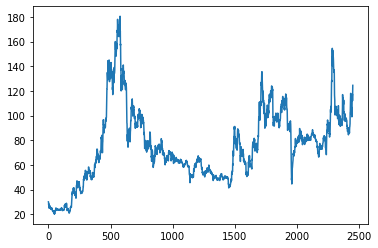

In [7]:
plt.plot(data['Close'])

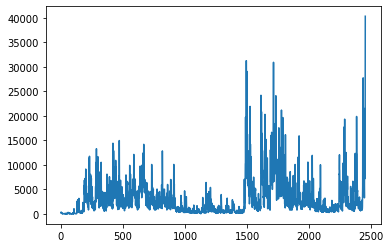

In [8]:
plt.plot(data['Volume'])

In [9]:
data.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')

In [10]:
scaler=MinMaxScaler(feature_range=(0,1))
col=['Open', 'High', 'Low', 'Volume']
data[col] = scaler.fit_transform(data[col])

In [11]:
close_scaler=MinMaxScaler(feature_range=(0,1))
data['Close']=close_scaler.fit_transform(np.array(data['Close']).reshape(-1,1))

In [12]:
def create_dataset(data, time_step=100):
    X,Y = [],[]
    for i in range(len(data)-time_step-5+1):
        col=['Open','High','Low','Close','Volume']
        temp=data.iloc[i:(i+time_step)][col].values.tolist()
        X.append(temp)
        col='Close'
        temp=data.iloc[i + time_step:i + time_step+5][col].values.tolist()
        Y.append(temp)
    return np.array(X),np.array(Y)

In [13]:
train_size=int(len(data)*train_test_ratio)
test_size=len(data)-train_size
train_data=data[:train_size]
test_data=data[-test_size:]

In [14]:
train_x, train_y = create_dataset(train_data)
test_x, test_y = create_dataset(test_data)

In [15]:
print(train_x.shape, train_y.shape)
print(test_x.shape, test_y.shape)

(1857, 100, 5) (1857, 5)
(387, 100, 5) (387, 5)


In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Dropout

In [17]:
model=Sequential()
n_neurons = train_x.shape[1] * train_x.shape[2]

model.add(LSTM(n_neurons,return_sequences=True,input_shape=(train_x.shape[1],train_x.shape[2])))
model.add(LSTM(n_neurons,return_sequences=True))
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(25, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='relu'))
model.compile(optimizer='adam', loss='mse')

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 500)          1012000   
                                                                 
 lstm_1 (LSTM)               (None, 100, 500)          2002000   
                                                                 
 lstm_2 (LSTM)               (None, 500)               2002000   
                                                                 
 dense (Dense)               (None, 100)               50100     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 25)                2525      
                                                                 
 dropout_1 (Dropout)         (None, 25)                0

In [19]:
epochs = 100
batch_size = 64
history = model.fit(train_x,
                    train_y, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(test_x, test_y)
                   )

Epoch 1/100
30/30 [==============================] - 10s 214ms/step - loss: 0.0821 - val_loss: 0.0357
Epoch 2/100
30/30 [==============================] - 5s 181ms/step - loss: 0.0616 - val_loss: 0.0291
Epoch 3/100
30/30 [==============================] - 5s 181ms/step - loss: 0.0423 - val_loss: 0.0094
Epoch 4/100
30/30 [==============================] - 5s 180ms/step - loss: 0.0348 - val_loss: 0.0279
Epoch 5/100
30/30 [==============================] - 5s 181ms/step - loss: 0.0275 - val_loss: 0.0032
Epoch 6/100
30/30 [==============================] - 5s 181ms/step - loss: 0.0220 - val_loss: 0.0039
Epoch 7/100
30/30 [==============================] - 5s 181ms/step - loss: 0.0175 - val_loss: 0.0246
Epoch 8/100
30/30 [==============================] - 5s 182ms/step - loss: 0.0174 - val_loss: 0.0116
Epoch 9/100
30/30 [==============================] - 5s 181ms/step - loss: 0.0146 - val_loss: 0.0036
Epoch 10/100
30/30 [==============================] - 5s 182ms/step - loss: 0.0127 - val_l

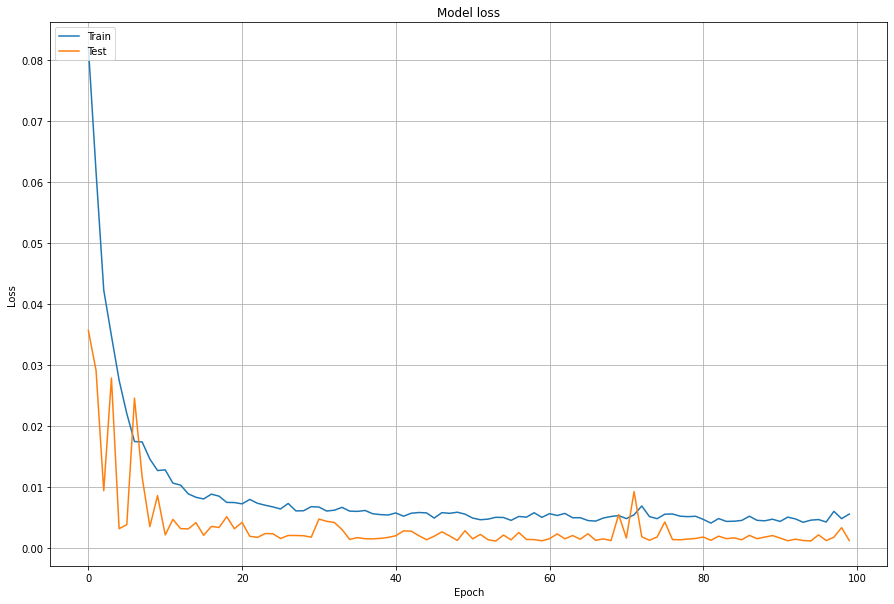

In [31]:
fig, ax = plt.subplots(figsize=(15, 10), sharex=True)
plt.plot(history.history["loss"])
plt.plot(history.history['val_loss'])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
# ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.savefig("loss.png",dpi=500)
plt.show()

In [38]:
train_predict=model.predict(train_x)
test_predict=model.predict(test_x)

In [41]:
temp=math.sqrt(mean_squared_error(train_y,train_predict))
close_scaler.inverse_transform([[temp]])

array([[26.00104266]])

In [42]:
temp=math.sqrt(mean_squared_error(test_y,test_predict))
close_scaler.inverse_transform([[temp]])

array([[26.01443998]])

In [43]:
# MAPE
MAPE = np.mean((np.abs(np.subtract(test_y, test_predict)/ test_y))) * 100

5.385215203336681

In [44]:
# MDAPE
np.median((np.abs(np.subtract(test_y, test_predict)/ test_y)) ) * 100

4.162295054562104

In [24]:
train_predict=[close_scaler.inverse_transform(i.reshape(-1,1)) for i in train_predict]
test_predict=[close_scaler.inverse_transform(i.reshape(-1,1)) for i in test_predict]

In [25]:
def five2one(five):
    one = [[] for _ in range(len(five)+4)]
    for i in range(len(five)):
        for j in range(5):
            one[i+j].append(float(five[i][j]))
    return [sum(i)/len(i) for i in one]

In [26]:
single_train_predict = five2one(train_predict)
single_test_predict = five2one(test_predict)

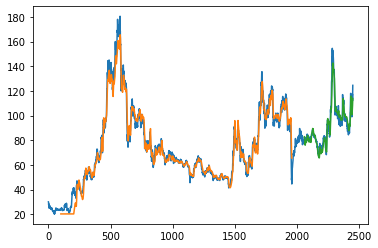

In [27]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(data['Close'])
trainPredictPlot[:] = np.nan
trainPredictPlot[look_back:len(single_train_predict)+look_back] = single_train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(data['Close'])
testPredictPlot[:] = np.nan
testPredictPlot[-len(single_test_predict):] = single_test_predict
# plot baseline and predictions
plt.plot(close_scaler.inverse_transform(np.array(data['Close']).reshape(-1,1)))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.savefig("result.png",dpi=2000)
plt.show()